classification without pretrain 

In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
import os
import random

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [4]:
version = "v10-2c"

OUTPUT_DIR = '/root/' + version + '/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [5]:
def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

In [6]:
class CFG:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_classes = 10
    batch_size = 256

In [7]:
transform_train = transforms.Compose([transforms.Resize((64,64)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])
 
 
transform = transforms.Compose([transforms.Resize((64,64)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

training_dataset = datasets.CIFAR10(root='/root/', train=True, download=True, transform=transform_train) # Data augmentation is only done on training images
validation_dataset = datasets.CIFAR10(root='/root/', train=False, download=True, transform=transform)
 
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=CFG.batch_size, shuffle=True) # Batch size of 100 i.e to work with 100 images at a time
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = CFG.batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [8]:
def im_convert(tensor):  
  image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [9]:
# Different classes in CIPHAR 10 dataset. 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

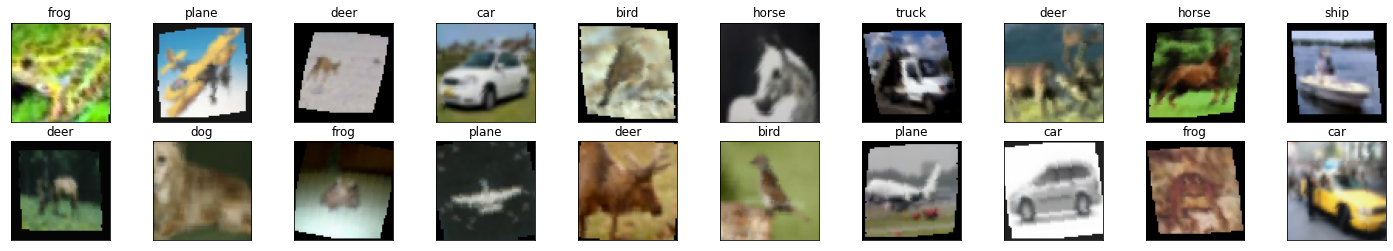

In [10]:
# We iter the batch of images to display
dataiter = iter(training_loader) # converting our train_dataloader to iterable so that we can iter through it. 
images, labels = dataiter.next() #going from 1st batch of 100 images to the next batch
fig = plt.figure(figsize=(25, 4)) 

# We plot 20 images from our train_dataset
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) 
  plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
  ax.set_title(classes[labels[idx].item()])

In [11]:
import hydra
from omegaconf import DictConfig
import logging

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, resnet34
from torchvision import transforms
from tqdm import tqdm
import glob

class SimCLR(nn.Module):
    def __init__(self, base_encoder, projection_dim=128):
        super().__init__()
        self.enc = base_encoder(pretrained=False)  # load model from torchvision.models without pretrained weights.
        self.feature_dim = self.enc.fc.in_features

        # Customize for CIFAR10. Replace conv 7x7 with conv 3x3, and remove first max pooling.
        # See Section B.9 of SimCLR paper.
        self.enc.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.enc.maxpool = nn.Identity()
        self.enc.fc = nn.Identity()  # remove final fully connected layer.

        # Add MLP projection.
        self.projection_dim = projection_dim
        self.projector = nn.Sequential(nn.Linear(self.feature_dim, 2048),
                                       nn.ReLU(),
                                       nn.Linear(2048, projection_dim))
        self.fc1 = nn.Linear(projection_dim, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        feature = self.enc(x)
        projection = self.projector(feature)
        return self.fc2(self.fc1(projection))

    

In [12]:
import torch
model = SimCLR(eval('resnet18'), projection_dim=128)
model.load_state_dict(
        torch.load("v10-2c-pretrain/model.pth", map_location="cpu"), strict = False
    )
model.to(CFG.device) # run our model on cuda GPU for faster results
print("")

In [13]:
criterion = nn.CrossEntropyLoss() # same as categorical_crossentropy loss used in Keras models which runs on Tensorflow
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002) # fine tuned the lr

In [14]:
epochs = 25
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
LOGGER.info('Step,Train Loss,Train Auc,Valid Loss,Valid Auc')
for e in range(epochs): # training our model, put input according to every batch.
  
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    train_num = 0
    val_num = 0

    tqdm_bar = tqdm(training_loader, desc=f'Training Epoch {e} ', total=int(len(training_loader)))
    for i, (inputs, labels) in enumerate(tqdm_bar):
        inputs = inputs.to(CFG.device) # input to device as our model is running in mentioned device.
        labels = labels.to(CFG.device)
        
        model.train()
        outputs = model(inputs) # every batch of 100 images are put as an input.
        loss = criterion(outputs, labels) # Calc loss after each batch i/p by comparing it to actual labels. 

        optimizer.zero_grad() #setting the initial gradient to 0
        loss.backward() # backpropagating the loss
        optimizer.step() # updating the weights and bias values for every single step.

        _, preds = torch.max(outputs, 1) # taking the highest value of prediction.
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data) # calculating te accuracy by taking the sum of all the correct predictions in a batch.
        
        train_num += len(preds)
        
        tqdm_bar.set_postfix(train_loss=running_loss/(i+1), train_accuracy=running_corrects.item()/(train_num))
    else:
        with torch.no_grad(): # we do not need gradient for validation.
            tqdm_bar = tqdm(validation_loader, desc=f'Validation Epoch {e} ', total=int(len(validation_loader)))
            for i, (val_inputs, val_labels) in enumerate(tqdm_bar):
                val_inputs = val_inputs.to(CFG.device)
                val_labels = val_labels.to(CFG.device)
                
                #t = torch.randint(0, 4000, (len(val_labels),), device=dist_util.dev()).long()
                model.eval()
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                
                val_num += len(val_preds)
                
                tqdm_bar.set_postfix(val_loss=val_running_loss/(i+1), val_accuracy=val_running_corrects.item()/(val_num))
      
        epoch_loss = running_loss/len(training_loader) # loss per epoch
        epoch_acc = running_corrects.float()/ train_num # accuracy per epoch
        running_loss_history.append(epoch_loss) # appending for displaying 
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/ val_num
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('epoch :', (e+1))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
        # LOGGER.info('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        # LOGGER.info('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
        LOGGER.info('{:d}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format((e+1) * len(training_loader), epoch_loss, epoch_acc.item(), val_epoch_loss, val_epoch_acc.item()))

Step,Train Loss,Train Auc,Valid Loss,Valid Auc
Validation Epoch 0 : 100%|██████████| 40/40 [00:05<00:00,  7.41it/s, val_accuracy=0.792, val_loss=0.614]
196, 0.6865, 0.7610, 0.6143, 0.7921


epoch : 1
training loss: 0.6865, acc 0.7610 
validation loss: 0.6143, validation acc 0.7921 


Validation Epoch 1 : 100%|██████████| 40/40 [00:05<00:00,  6.99it/s, val_accuracy=0.854, val_loss=0.429]
392, 0.4182, 0.8551, 0.4294, 0.8540


epoch : 2
training loss: 0.4182, acc 0.8551 
validation loss: 0.4294, validation acc 0.8540 


Validation Epoch 2 : 100%|██████████| 40/40 [00:04<00:00,  8.04it/s, val_accuracy=0.874, val_loss=0.376]
588, 0.3505, 0.8794, 0.3757, 0.8743


epoch : 3
training loss: 0.3505, acc 0.8794 
validation loss: 0.3757, validation acc 0.8743 


Validation Epoch 3 : 100%|██████████| 40/40 [00:05<00:00,  7.31it/s, val_accuracy=0.882, val_loss=0.348]
784, 0.3037, 0.8951, 0.3478, 0.8824


epoch : 4
training loss: 0.3037, acc 0.8951 
validation loss: 0.3478, validation acc 0.8824 


Validation Epoch 4 : 100%|██████████| 40/40 [00:05<00:00,  7.37it/s, val_accuracy=0.889, val_loss=0.332]
980, 0.2658, 0.9064, 0.3317, 0.8895


epoch : 5
training loss: 0.2658, acc 0.9064 
validation loss: 0.3317, validation acc 0.8895 


Validation Epoch 5 : 100%|██████████| 40/40 [00:05<00:00,  7.51it/s, val_accuracy=0.895, val_loss=0.319]
1176, 0.2405, 0.9153, 0.3186, 0.8947


epoch : 6
training loss: 0.2405, acc 0.9153 
validation loss: 0.3186, validation acc 0.8947 


Validation Epoch 6 : 100%|██████████| 40/40 [00:05<00:00,  6.77it/s, val_accuracy=0.901, val_loss=0.31] 
1372, 0.2147, 0.9242, 0.3102, 0.9011


epoch : 7
training loss: 0.2147, acc 0.9242 
validation loss: 0.3102, validation acc 0.9011 


Validation Epoch 7 : 100%|██████████| 40/40 [00:04<00:00,  8.10it/s, val_accuracy=0.891, val_loss=0.365]
1568, 0.1969, 0.9313, 0.3651, 0.8915


epoch : 8
training loss: 0.1969, acc 0.9313 
validation loss: 0.3651, validation acc 0.8915 


Validation Epoch 8 : 100%|██████████| 40/40 [00:06<00:00,  6.17it/s, val_accuracy=0.904, val_loss=0.301]
1764, 0.1856, 0.9353, 0.3011, 0.9039


epoch : 9
training loss: 0.1856, acc 0.9353 
validation loss: 0.3011, validation acc 0.9039 


Validation Epoch 9 : 100%|██████████| 40/40 [00:05<00:00,  7.06it/s, val_accuracy=0.897, val_loss=0.354]
1960, 0.1617, 0.9441, 0.3535, 0.8975


epoch : 10
training loss: 0.1617, acc 0.9441 
validation loss: 0.3535, validation acc 0.8975 


Validation Epoch 10 : 100%|██████████| 40/40 [00:05<00:00,  7.50it/s, val_accuracy=0.908, val_loss=0.299]
2156, 0.1580, 0.9443, 0.2988, 0.9082


epoch : 11
training loss: 0.1580, acc 0.9443 
validation loss: 0.2988, validation acc 0.9082 


Validation Epoch 11 : 100%|██████████| 40/40 [00:05<00:00,  6.75it/s, val_accuracy=0.916, val_loss=0.289]
2352, 0.1434, 0.9497, 0.2889, 0.9163


epoch : 12
training loss: 0.1434, acc 0.9497 
validation loss: 0.2889, validation acc 0.9163 


Validation Epoch 12 : 100%|██████████| 40/40 [00:04<00:00,  8.04it/s, val_accuracy=0.911, val_loss=0.33] 
2548, 0.1335, 0.9539, 0.3303, 0.9107


epoch : 13
training loss: 0.1335, acc 0.9539 
validation loss: 0.3303, validation acc 0.9107 


Validation Epoch 13 : 100%|██████████| 40/40 [00:05<00:00,  6.93it/s, val_accuracy=0.904, val_loss=0.349]
2744, 0.1226, 0.9578, 0.3489, 0.9039


epoch : 14
training loss: 0.1226, acc 0.9578 
validation loss: 0.3489, validation acc 0.9039 


Validation Epoch 14 : 100%|██████████| 40/40 [00:05<00:00,  7.25it/s, val_accuracy=0.911, val_loss=0.305]
2940, 0.1210, 0.9576, 0.3050, 0.9112


epoch : 15
training loss: 0.1210, acc 0.9576 
validation loss: 0.3050, validation acc 0.9112 


Validation Epoch 15 : 100%|██████████| 40/40 [00:06<00:00,  6.10it/s, val_accuracy=0.922, val_loss=0.275]
3136, 0.1116, 0.9608, 0.2747, 0.9216


epoch : 16
training loss: 0.1116, acc 0.9608 
validation loss: 0.2747, validation acc 0.9216 


Validation Epoch 16 : 100%|██████████| 40/40 [00:05<00:00,  7.05it/s, val_accuracy=0.912, val_loss=0.318]
3332, 0.1041, 0.9639, 0.3183, 0.9117


epoch : 17
training loss: 0.1041, acc 0.9639 
validation loss: 0.3183, validation acc 0.9117 


Validation Epoch 17 : 100%|██████████| 40/40 [00:05<00:00,  7.53it/s, val_accuracy=0.92, val_loss=0.317] 
3528, 0.0995, 0.9656, 0.3172, 0.9202


epoch : 18
training loss: 0.0995, acc 0.9656 
validation loss: 0.3172, validation acc 0.9202 


Validation Epoch 18 : 100%|██████████| 40/40 [00:05<00:00,  7.48it/s, val_accuracy=0.905, val_loss=0.352]
3724, 0.0877, 0.9688, 0.3518, 0.9047


epoch : 19
training loss: 0.0877, acc 0.9688 
validation loss: 0.3518, validation acc 0.9047 


Validation Epoch 19 : 100%|██████████| 40/40 [00:05<00:00,  6.84it/s, val_accuracy=0.906, val_loss=0.365]
3920, 0.0921, 0.9688, 0.3648, 0.9063


epoch : 20
training loss: 0.0921, acc 0.9688 
validation loss: 0.3648, validation acc 0.9063 


Validation Epoch 20 : 100%|██████████| 40/40 [00:05<00:00,  7.28it/s, val_accuracy=0.915, val_loss=0.316]
4116, 0.0829, 0.9718, 0.3163, 0.9155


epoch : 21
training loss: 0.0829, acc 0.9718 
validation loss: 0.3163, validation acc 0.9155 


Validation Epoch 21 : 100%|██████████| 40/40 [00:05<00:00,  7.36it/s, val_accuracy=0.92, val_loss=0.3]   
4312, 0.0862, 0.9701, 0.2995, 0.9204


epoch : 22
training loss: 0.0862, acc 0.9701 
validation loss: 0.2995, validation acc 0.9204 


Validation Epoch 22 : 100%|██████████| 40/40 [00:05<00:00,  7.39it/s, val_accuracy=0.918, val_loss=0.291]
4508, 0.0741, 0.9741, 0.2905, 0.9184


epoch : 23
training loss: 0.0741, acc 0.9741 
validation loss: 0.2905, validation acc 0.9184 


Validation Epoch 23 : 100%|██████████| 40/40 [00:05<00:00,  7.71it/s, val_accuracy=0.914, val_loss=0.351]
4704, 0.0732, 0.9741, 0.3510, 0.9137


epoch : 24
training loss: 0.0732, acc 0.9741 
validation loss: 0.3510, validation acc 0.9137 


Validation Epoch 24 : 100%|██████████| 40/40 [00:05<00:00,  7.06it/s, val_accuracy=0.921, val_loss=0.304]
4900, 0.0710, 0.9752, 0.3036, 0.9210


epoch : 25
training loss: 0.0710, acc 0.9752 
validation loss: 0.3036, validation acc 0.9210 
